In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('D:/dataset/AirPassengers.csv')

In [3]:
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
data.size

288

In [5]:
data.columns

Index(['Month', 'Passengers'], dtype='object')

In [6]:
data.info

<bound method DataFrame.info of        Month  Passengers
0    1949-01         112
1    1949-02         118
2    1949-03         132
3    1949-04         129
4    1949-05         121
..       ...         ...
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432

[144 rows x 2 columns]>

In [7]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
data.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [9]:
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)
data=data.set_index(['Month'])
data.head(20)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [10]:
## plot graph

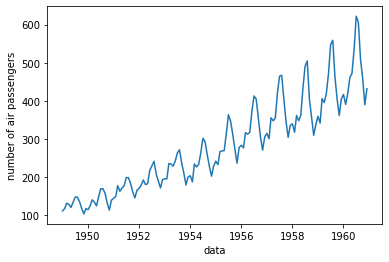

In [11]:
plt.xlabel('data')
plt.ylabel('number of air passengers')
plt.plot(data)

In [12]:
import statsmodels.api as sm
import matplotlib

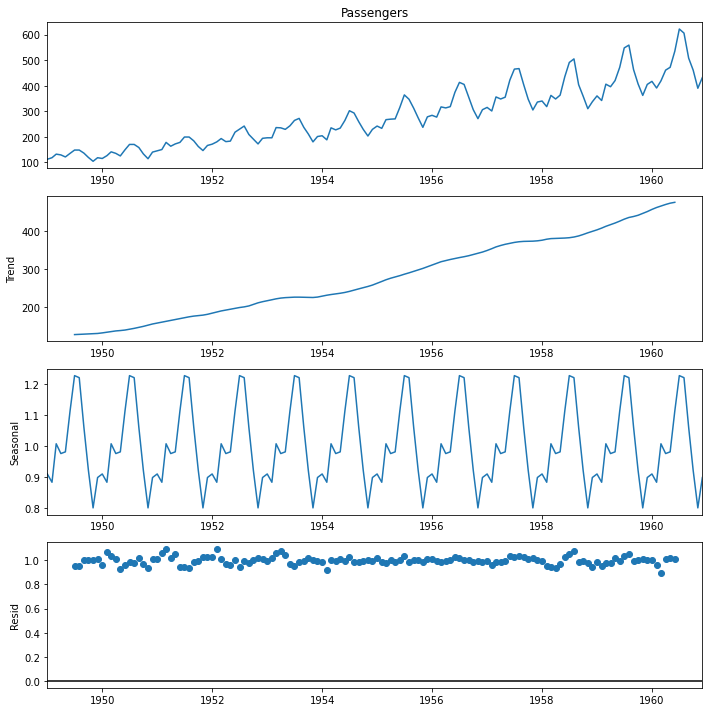

In [13]:
airpax_decompose=sm.tsa.seasonal_decompose(data['Passengers'],model="multiplicative")
matplotlib.rcParams['figure.figsize']=(10,10)
airpax_decompose.plot()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

In [44]:
#test wether timeseries is stationary or not
def test_stationary(timeseries):
    #determine rolling statistics
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig=plt.plot(timeseries, color='blue',label='original')
    mean=plt.plot(rolmean,color='red',label='rolling mean')
    std=plt.plot(rolstd,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title('rolling mean and std deviation')
    plt.show(block=False)
    
    #perform ADF dickey fuller
    print('Results of ADF test')
    dftest=adfuller(timeseries['Passengers'],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['test statistics','P-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical values(%s)'%key]=value
    print(dfoutput)

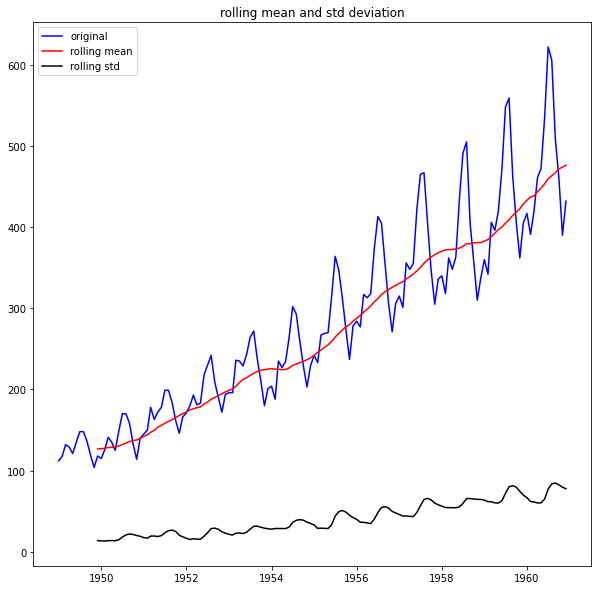

Results of ADF test
test statistics                  0.815369
P-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
critical values(1%)             -3.481682
critical values(5%)             -2.884042
critical values(10%)            -2.578770
dtype: float64


In [41]:
test_stationary(data)

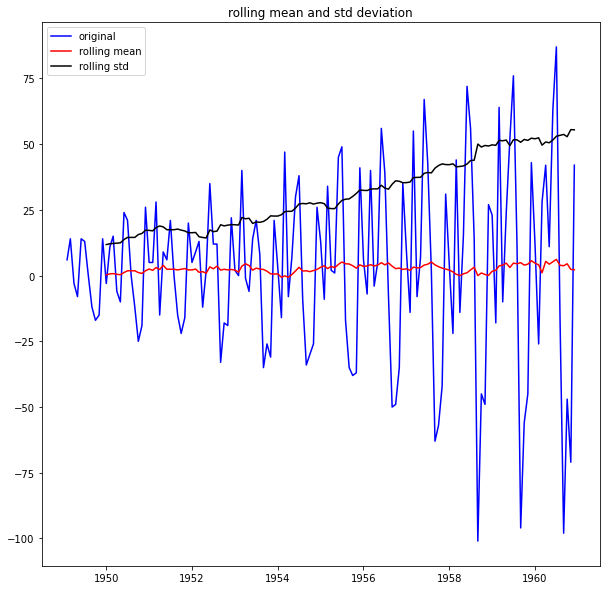

Results of ADF test
test statistics                 -2.829267
P-value                          0.054213
#lags used                      12.000000
number of observations used    130.000000
critical values(1%)             -3.481682
critical values(5%)             -2.884042
critical values(10%)            -2.578770
dtype: float64


In [17]:
airpax_df1=data.diff(periods=1)
airpax_df1.dropna(inplace=True)
test_stationary(airpax_df1)

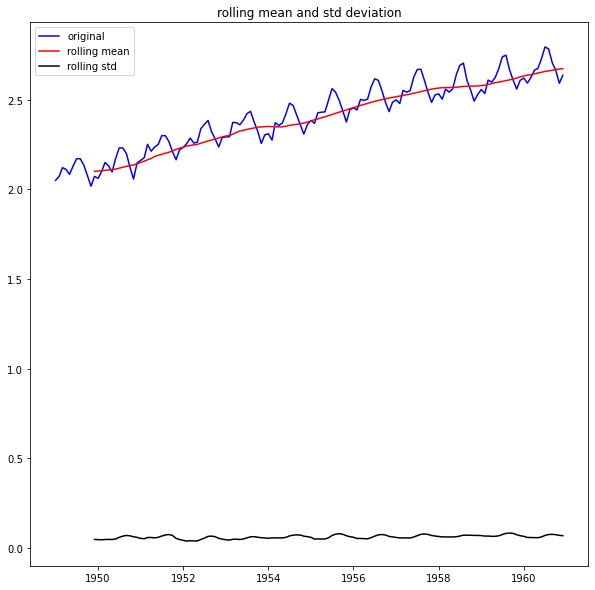

Results of ADF test
test statistics                 -1.717017
P-value                          0.422367
#lags used                      13.000000
number of observations used    130.000000
critical values(1%)             -3.481682
critical values(5%)             -2.884042
critical values(10%)            -2.578770
dtype: float64


In [18]:
airpax_log=np.log10(data)
airpax_log.dropna(inplace=True)
test_stationary(airpax_log)

In [19]:
#HOLT EXPONENTIAL

In [47]:
train=data[0:int(len(data)*.80)]
test=data[int(len(data)*.80):]
train_log=np.log(train['Passengers'])

In [48]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true,y_pred=np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt

In [50]:
model_airpax=ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=24,trend='add',seasonal='mul').fit(optimized=True)

In [24]:
airpax_Holt=test.copy()

In [25]:
airpax_Holt['Holt']=model_airpax.forecast(len(test['Passengers']))

In [26]:
mean_absolute_percentage_error(test['Passengers'],airpax_Holt['Holt'])

5.147608368226583

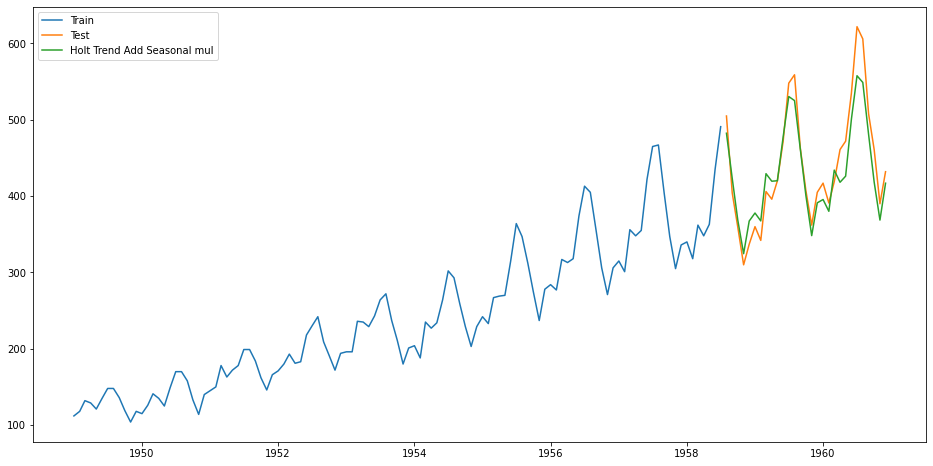

In [27]:
airpax_Holt['Pax']=model_airpax.forecast(len(test['Passengers']))
plt.figure(figsize=(16,8))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(airpax_Holt['Holt'],label='Holt Trend Add Seasonal mul')
plt.legend(loc=0)

# plotting ACG &PCF

In [28]:
import statsmodels.tsa.api as smt

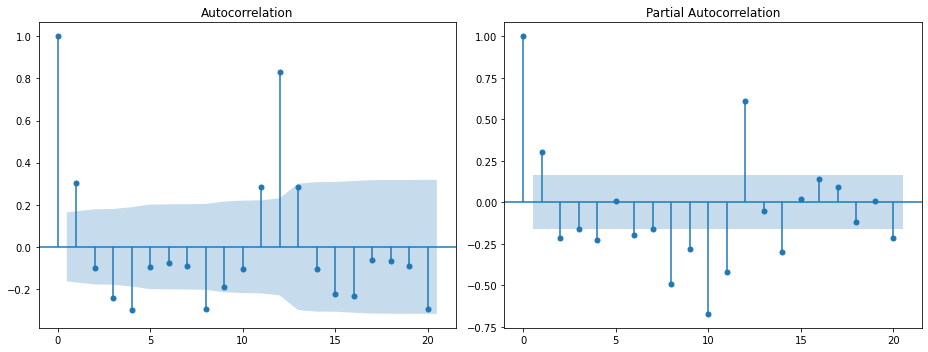

In [29]:
fig, axes=plt.subplots(1,2)
fig.set_figwidth(13)
fig.set_figheight(5)
smt.graphics.plot_acf(airpax_df1,lags=20,ax=axes[0])
smt.graphics.plot_pacf(airpax_df1,lags=20,ax=axes[1])
plt.tight_layout()

In [30]:
import itertools

In [31]:
#Define the p,d,q parameters to take any value btw 0 and 2
p=d=q=range(0,2)
#generate all different combinations of seasonal p,d and q triplets
seasonal_pdq=[(x[0],x[1],x[2],12)for x in list(itertools.product(p,d,q))]

In [32]:
#the aic lets us know how well our model fits the data set with out 
best_aic=np.inf
best_pdq=None
best_seasonal_pdq=None
temp_model=None
train_log=np.log10(train['Passengers'])

In [33]:
mod=sm.tsa.statespace.SARIMAX(train_log,
                             order=(0,1,1),seasonal_order=(1,0,1,12),
                             enforce_stationarity=True)
best_results=mod.fit()
print(best_results.summary())

C:\Users\win\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\win\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 292.664
Date:                            Mon, 01 Aug 2022   AIC                           -577.328
Time:                                    19:54:06   BIC                           -566.384
Sample:                                01-01-1949   HQIC                          -572.887
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2742      0.083     -3.311      0.001      -0.437      -0.112
ar.S.L12       0.9958      0.004   

In [34]:
#Get forecast 36steps(36 years) ahead in future n_steps=36

In [35]:
n_steps=36
pred_uc_99=best_results.get_forecast(steps=36,alpha=0.01) #alpha=0.01 significes the 99% confidence interval
pred_uc_95=best_results.get_forecast(steps=36,alpha=0.05) #alpha=0.05 significes the 95% confidence interval

In [36]:
#Get confidence interval 95% & 99% of the forecast
pred_ci_99=pred_uc_99.conf_int()
pred_ci_95=pred_uc_95.conf_int()

In [37]:
n_steps=36
idx=pd.date_range(data.index[-1],periods=n_steps,freq='MS') # MS stands for month start frequency
fc_95=pd.DataFrame(np.column_stack([np.power(10,pred_uc_95.predicted_mean),np.power(10,pred_ci_95)]),index=idx,columns=['forecast','lower_ci_95','upper_ci_95'])
fc_99=pd.DataFrame(np.column_stack([np.power(10,pred_ci_99)]),index=idx,columns=['lower_ci_99','upper_ci_99'])
fc_all=fc_95.combine_first(fc_99)
fc_all=fc_all[['forecast','lower_ci_95','upper_ci_95','lower_ci_99','upper_ci_99']]
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1960-12-01,483.201547,450.183537,518.641210,450.183537,518.641210
1961-01-01,425.587905,389.949284,464.483646,389.949284,464.483646
1961-02-01,370.927038,335.150617,410.522494,335.150617,410.522494
1961-03-01,326.357060,291.284407,365.652702,291.284407,365.652702
1961-04-01,367.476223,324.375055,416.304436,324.375055,416.304436


In [38]:
#plot the forecast along with the confidence band

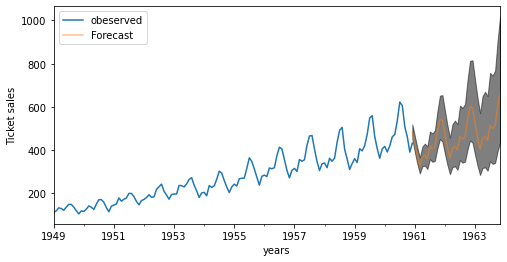

In [39]:
axis=data['Passengers'].plot(label='obeserved',figsize=(8,4))
fc_all['forecast'].plot(ax=axis,label='Forecast',alpha=0.5)
axis.fill_between(fc_all.index,fc_all['lower_ci_95'],fc_all['upper_ci_95'],color='k',alpha=0.5)
axis.set_xlabel('years')
axis.set_ylabel('Ticket sales')
plt.legend(loc='upper left')
plt.show()